In [ ]:
# !pip install torch torchvision pandas matplotlib scikit-learn seaborn tensorboard pillow fvcore
# !pip install --upgrade tensorflow tensorboard

In [2]:
# Data Manipulation & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

# PyTorch & Related
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet50, ResNet50_Weights
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform
from tqdm import tqdm

# Computer Vision
from torchvision import transforms
from PIL import Image

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch version: 2.2.2+cu121
CUDA available: True
GPU: NVIDIA A10G


In [4]:
os.chdir("/home/ubuntu")
print("Current working directory:", os.getcwd())

Current working directory: /home/ubuntu


In [5]:
# File Paths
train_csv_path = "datasets/FF++(HQ)/FF++(HQ)_CSV/combined_training_original_cross_data_full_with_augmentation.csv"
val_csv_path = "datasets/FF++(HQ)/FF++(HQ)_CSV/combined_validation_original_cross_data_full_with_augmentation.csv"
test_csv_path = "datasets/FF++(HQ)/FF++(HQ)_CSV/combined_testing_original_cross_data_full_with_augmentation.csv"
celebdf_path = "datasets/celebdf_v2/celeb_df_output_file.csv"
wilddeepfake_path = "datasets/wilddeepfake/wilddeepfake_test.csv"

# Hyperparameters and Settings
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 100

# Model and Logging Paths
SAVE_PATH = "Pretrained_FFHQ/ResNet_Models/Resnet50_model.pth"
LOG_DIR = "Pretrained_FFHQ/ResNet_Models/Resnet50_logss"

# Ensure directories exist
os.makedirs(os.path.dirname(SAVE_PATH), exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

# TensorBoard Writer
writer = SummaryWriter(log_dir=LOG_DIR)

In [ ]:
# Standard ImageNet Normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [7]:
class DeepfakeDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = self.df.iloc[index]['path']
        label = int(self.df.iloc[index]['label'])

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            image = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE))

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Initialize datasets
train_dataset = DeepfakeDataset(train_csv_path, transform=train_transform)
val_dataset = DeepfakeDataset(val_csv_path, transform=val_test_transform)
test_dataset = DeepfakeDataset(test_csv_path, transform=val_test_transform)
celebdf_dataset = DeepfakeDataset(celebdf_path, transform=val_test_transform)
wilddeepfake_dataset = DeepfakeDataset(wilddeepfake_path, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
celebdf_loader = DataLoader(celebdf_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
wilddeepfake_loader = DataLoader(wilddeepfake_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [ ]:
def visualize_augmentations(dataset, num_images=5):
    from torchvision.utils import make_grid

    fig = plt.figure(figsize=(15, 3))
    for i in range(num_images):
        image, label = dataset[i]

        # Unnormalize if normalized
        if isinstance(image, torch.Tensor):
            image = image.clone()
            image = image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = image + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            image = image.permute(1, 2, 0).numpy()
            image = np.clip(image, 0, 1)

        ax = fig.add_subplot(1, num_images, i + 1)
        ax.imshow(image)
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

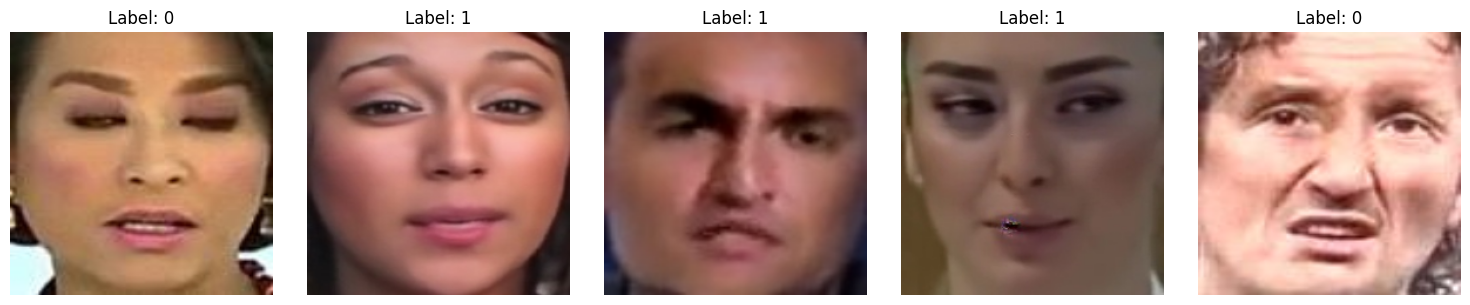

In [ ]:
visualize_augmentations(train_dataset, num_images=5)

# ResNet50

In [ ]:
# Load pre-trained ResNet50
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace and unfreeze the final classification layer
model.fc = nn.Linear(model.fc.in_features, 2)
for param in model.fc.parameters():
    param.requires_grad = True

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)  # Only optimize the final layer
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Tracking
train_losses, val_losses, val_accuracies = [], [], []
early_stop_patience = 5
early_stop_counter = 0
best_val_loss = float('inf')

Using device: cuda


In [12]:
# Print model parameter statistics
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\nTrainable parameters:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")

Total parameters: 23,512,130
Trainable parameters: 4,098

Trainable parameters:
fc.weight: torch.Size([2, 2048])
fc.bias: torch.Size([2])


In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [15]:
best_val_loss = float('inf')
early_stop_counter = 0
early_stop_patience = 5


# Initialize tracking lists before the training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    print(f"\n Epoch {epoch + 1}/{NUM_EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Accuracy/Train", train_acc, epoch)
    writer.add_scalar("Loss/Val", val_loss, epoch)
    writer.add_scalar("Accuracy/Val", val_acc, epoch)

    print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), SAVE_PATH)
        print(f" Saved best model to: {SAVE_PATH}")
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:
            print(" Early stopping triggered.")
            break

    scheduler.step()

writer.close()


 Epoch 1/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.50it/s]


 Train Loss: 0.3827, Train Acc: 84.31%
 Val Loss: 0.3151, Val Acc: 87.35%
 Saved best model to: Pretrained_FFHQ/ResNet_Models/Resnet50_model.pth

 Epoch 2/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.58it/s]


 Train Loss: 0.3203, Train Acc: 86.74%
 Val Loss: 0.3006, Val Acc: 88.01%
 Saved best model to: Pretrained_FFHQ/ResNet_Models/Resnet50_model.pth

 Epoch 3/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.52it/s]


 Train Loss: 0.3058, Train Acc: 87.24%
 Val Loss: 0.2978, Val Acc: 88.41%
 Saved best model to: Pretrained_FFHQ/ResNet_Models/Resnet50_model.pth

 Epoch 4/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:37<00:00, 28.16it/s]


 Train Loss: 0.2982, Train Acc: 87.63%
 Val Loss: 0.2867, Val Acc: 88.52%
 Saved best model to: Pretrained_FFHQ/ResNet_Models/Resnet50_model.pth

 Epoch 5/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.57it/s]


 Train Loss: 0.2933, Train Acc: 87.67%
 Val Loss: 0.2823, Val Acc: 88.30%
 Saved best model to: Pretrained_FFHQ/ResNet_Models/Resnet50_model.pth

 Epoch 6/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.56it/s]


 Train Loss: 0.2886, Train Acc: 87.92%
 Val Loss: 0.2872, Val Acc: 88.54%

 Epoch 7/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:37<00:00, 28.25it/s]


 Train Loss: 0.2895, Train Acc: 87.85%
 Val Loss: 0.2787, Val Acc: 88.52%
 Saved best model to: Pretrained_FFHQ/ResNet_Models/Resnet50_model.pth

 Epoch 8/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.43it/s]


 Train Loss: 0.2891, Train Acc: 87.97%
 Val Loss: 0.2790, Val Acc: 88.53%

 Epoch 9/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:37<00:00, 28.17it/s]


 Train Loss: 0.2887, Train Acc: 87.85%
 Val Loss: 0.2843, Val Acc: 88.54%

 Epoch 10/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.33it/s]


 Train Loss: 0.2877, Train Acc: 87.93%
 Val Loss: 0.2757, Val Acc: 88.39%
 Saved best model to: Pretrained_FFHQ/ResNet_Models/Resnet50_model.pth

 Epoch 11/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.42it/s]


 Train Loss: 0.2877, Train Acc: 87.90%
 Val Loss: 0.2805, Val Acc: 88.52%

 Epoch 12/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.56it/s]


 Train Loss: 0.2881, Train Acc: 87.86%
 Val Loss: 0.2756, Val Acc: 88.64%
 Saved best model to: Pretrained_FFHQ/ResNet_Models/Resnet50_model.pth

 Epoch 13/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.47it/s]


 Train Loss: 0.2880, Train Acc: 87.91%
 Val Loss: 0.2814, Val Acc: 88.38%

 Epoch 14/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.46it/s]


 Train Loss: 0.2876, Train Acc: 87.99%
 Val Loss: 0.2819, Val Acc: 88.51%

 Epoch 15/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.43it/s]


 Train Loss: 0.2871, Train Acc: 88.02%
 Val Loss: 0.2786, Val Acc: 88.41%

 Epoch 16/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.58it/s]


 Train Loss: 0.2872, Train Acc: 87.96%
 Val Loss: 0.2789, Val Acc: 88.35%

 Epoch 17/100


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1046/1046 [00:36<00:00, 28.42it/s]

 Train Loss: 0.2883, Train Acc: 87.92%
 Val Loss: 0.2835, Val Acc: 88.53%
 Early stopping triggered.


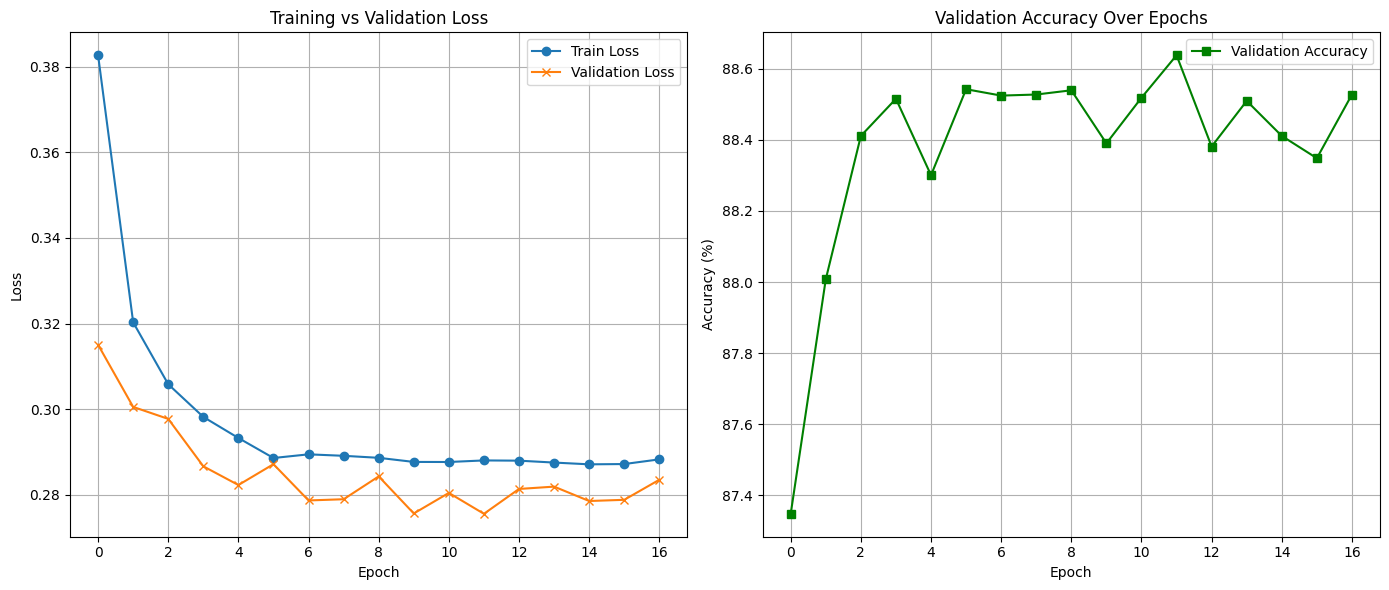

In [ ]:
plt.figure(figsize=(14, 6))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='s', color='green')
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
def test_model_with_probs(model, dataloader, device, name):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"{name}"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_probs)

In [18]:
def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    fnr = 1 - tpr
    abs_diffs = np.abs(fpr - fnr)
    min_index = np.argmin(abs_diffs)
    eer = (fpr[min_index] + fnr[min_index]) / 2
    threshold = thresholds[min_index]
    return eer, threshold

def plot_combined_roc_with_eer(score_label_tuples):
    plt.figure(figsize=(7, 7))
    for y_true, y_scores, label in score_label_tuples:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        auc_score = roc_auc_score(y_true, y_scores)
        eer, _ = calculate_eer(y_true, y_scores)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f}, EER = {eer:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves with AUC & EER")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [19]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap,
                xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [21]:
# Load best model
model.load_state_dict(torch.load(SAVE_PATH))
model.to(device)

# Predict
labels_test, probs_test = test_model_with_probs(model, test_loader, device, name="FFHQ Test Set")
labels_celeb, probs_celeb = test_model_with_probs(model, celebdf_loader, device, name="CelebDF")
labels_wild, probs_wild = test_model_with_probs(model, wilddeepfake_loader, device, name="WildDeepfake")

# Thresholding
preds_test = (probs_test >= 0.5).astype(int)
preds_celeb = (probs_celeb >= 0.5).astype(int)
preds_wild = (probs_wild >= 0.5).astype(int)

WildDeepfake: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2245/2245 [01:33<00:00, 24.12it/s]


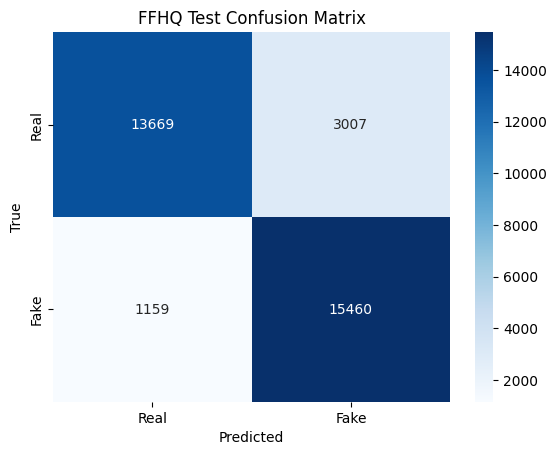

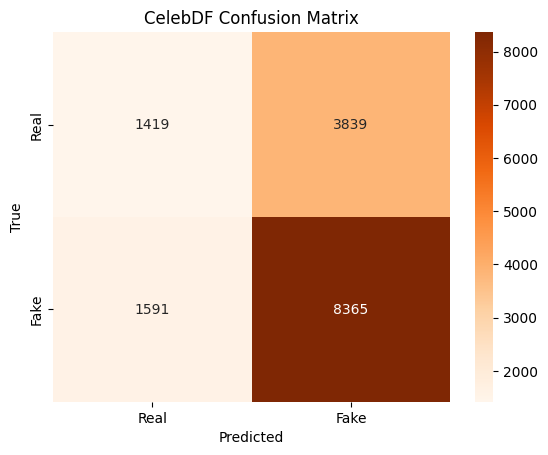

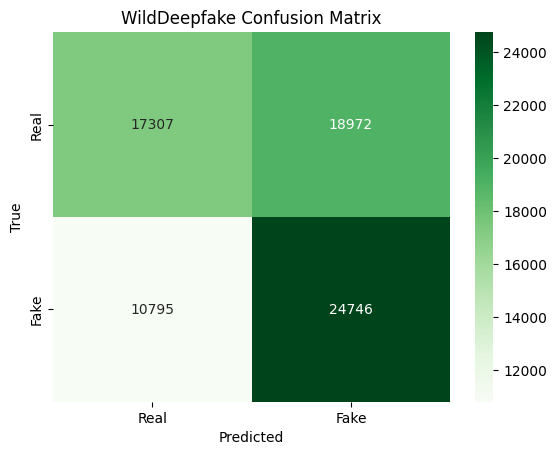

In [22]:
# Confusion Matrices
plot_confusion_matrix(labels_test, preds_test, title="FFHQ Test Confusion Matrix", cmap="Blues")
plot_confusion_matrix(labels_celeb, preds_celeb, title="CelebDF Confusion Matrix", cmap="Oranges")
plot_confusion_matrix(labels_wild, preds_wild, title="WildDeepfake Confusion Matrix", cmap="Greens")

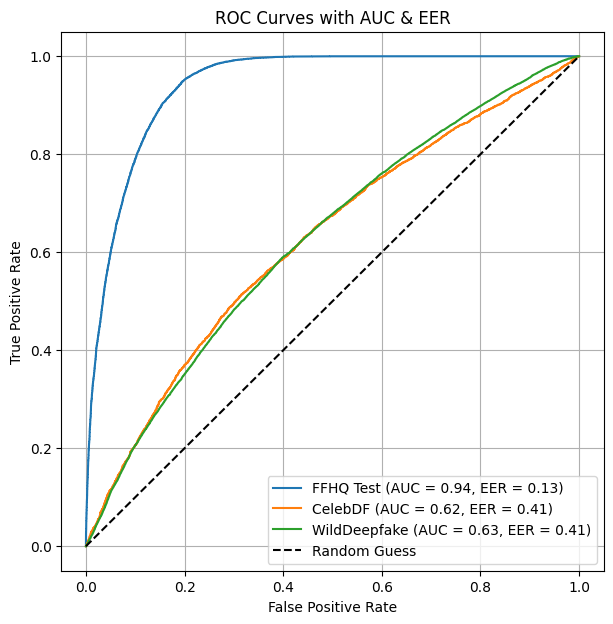

In [23]:
# ROC Curves
plot_combined_roc_with_eer([
    (labels_test, probs_test, "FFHQ Test"),
    (labels_celeb, probs_celeb, "CelebDF"),
    (labels_wild, probs_wild, "WildDeepfake")
])

In [24]:
# Classification reports

print("FFHQ Test Set Classification Report:")
print(classification_report(labels_test, preds_test, target_names=["Real", "Fake"]))

print("\nCelebDF Classification Report:")
print(classification_report(labels_celeb, preds_celeb, target_names=["Real", "Fake"]))

print("\nWildDeepfake Classification Report:")
print(classification_report(labels_wild, preds_wild, target_names=["Real", "Fake"]))

FFHQ Test Set Classification Report:
              precision    recall  f1-score   support

        Real       0.92      0.82      0.87     16676
        Fake       0.84      0.93      0.88     16619

    accuracy                           0.87     33295
   macro avg       0.88      0.87      0.87     33295
weighted avg       0.88      0.87      0.87     33295


CelebDF Classification Report:
              precision    recall  f1-score   support

        Real       0.47      0.27      0.34      5258
        Fake       0.69      0.84      0.75      9956

    accuracy                           0.64     15214
   macro avg       0.58      0.56      0.55     15214
weighted avg       0.61      0.64      0.61     15214


WildDeepfake Classification Report:
              precision    recall  f1-score   support

        Real       0.62      0.48      0.54     36279
        Fake       0.57      0.70      0.62     35541

    accuracy                           0.59     71820
   macro avg       0.5

# GradCam

In [25]:
# Initialize Grad-CAM once
cam = GradCAM(
    model=model,
    target_layers=[model.layer4[-1]]
)

def show_gradcam(loader, label_name="Sample", image_weight=0.5):
    model.eval()

    # Get a sample
    images, labels = next(iter(loader))
    img_tensor = images[0].unsqueeze(0).to(device)
    label = labels[0].item()

    # Get model prediction
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, pred_label = torch.max(probs, 1)
        pred_label = pred_label.item()
        confidence = confidence.item()

    # Grad-CAM for predicted class
    targets = [ClassifierOutputTarget(pred_label)]
    grayscale_cam = cam(input_tensor=img_tensor, targets=targets)[0]

    # De-normalize image (ImageNet stats)
    img_np = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = (img_np * std) + mean
    img_np = np.clip(img_np, 0, 1)

    # Overlay Grad-CAM heatmap
    vis = show_cam_on_image(img_np, grayscale_cam, use_rgb=True, image_weight=image_weight)

    # Show plot
    plt.figure(figsize=(5, 5))
    plt.imshow(vis)
    plt.title(
        f"{label_name} Grad-CAM\n"
        f"True: {'Fake' if label == 1 else 'Real'} | "
        f"Pred: {'Fake' if pred_label == 1 else 'Real'} ({confidence:.2f})"
    )
    plt.axis("off")
    plt.show()

In [27]:
def show_batch_gradcam(loader, title="Batch Grad-CAM", image_weight=0.5):
    model.eval()
    all_images, all_labels = [], []

    # Collect up to 1000 samples
    for imgs, lbls in loader:
        all_images.extend(imgs)
        all_labels.extend(lbls)
        if len(all_images) >= 1000:
            break

    # Sample 4 fake + 4 real
    indices_fake = [i for i, l in enumerate(all_labels) if l == 1]
    indices_real = [i for i, l in enumerate(all_labels) if l == 0]

    num_fake = min(4, len(indices_fake))
    num_real = min(4, len(indices_real))
    chosen_indices = random.sample(indices_fake, num_fake) + random.sample(indices_real, num_real)
    random.shuffle(chosen_indices)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for ax, idx in zip(axes.flatten(), chosen_indices):
        img = all_images[idx].unsqueeze(0).to(device)
        true_label = all_labels[idx].item()

        # Get prediction
        with torch.no_grad():
            output = model(img)
            probs = torch.softmax(output, dim=1)
            confidence, pred_label = torch.max(probs, 1)
            pred_label = pred_label.item()
            confidence = confidence.item()

        # Grad-CAM
        grayscale_cam = cam(input_tensor=img, targets=[ClassifierOutputTarget(pred_label)])[0]

        # De-normalize (ImageNet stats)
        img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = (img_np * std) + mean
        img_np = np.clip(img_np, 0, 1)

        # Overlay CAM
        vis = show_cam_on_image(img_np, grayscale_cam, use_rgb=True, image_weight=image_weight)

        ax.imshow(vis)
        ax.set_title(
            f"True: {'Fake' if true_label else 'Real'}\n"
            f"Pred: {'Fake' if pred_label else 'Real'} ({confidence:.2f})",
            fontsize=12
        )
        ax.axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

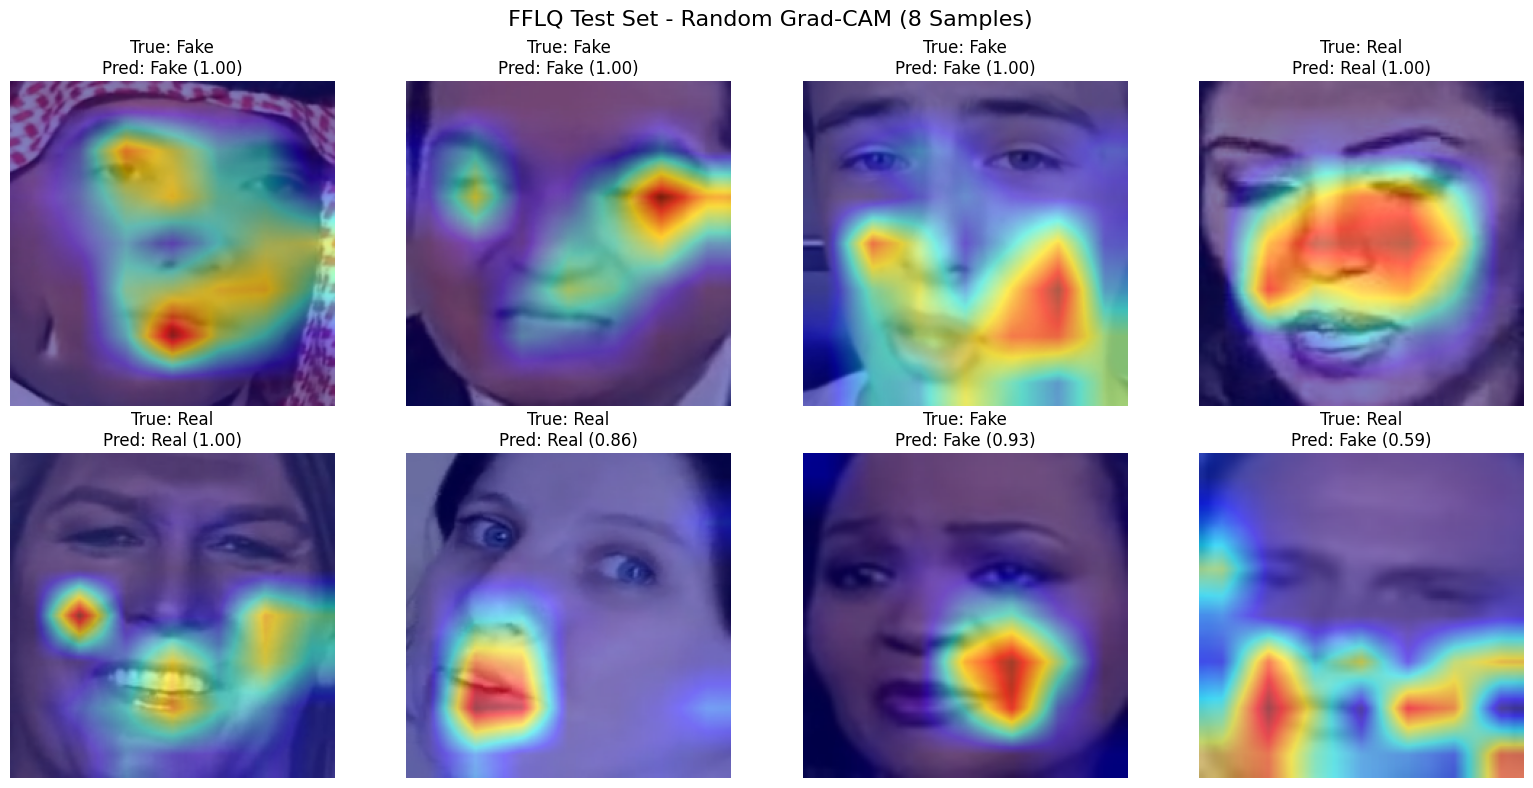

In [28]:
show_batch_gradcam(test_loader, title=" FFLQ Test Set - Random Grad-CAM (8 Samples)")

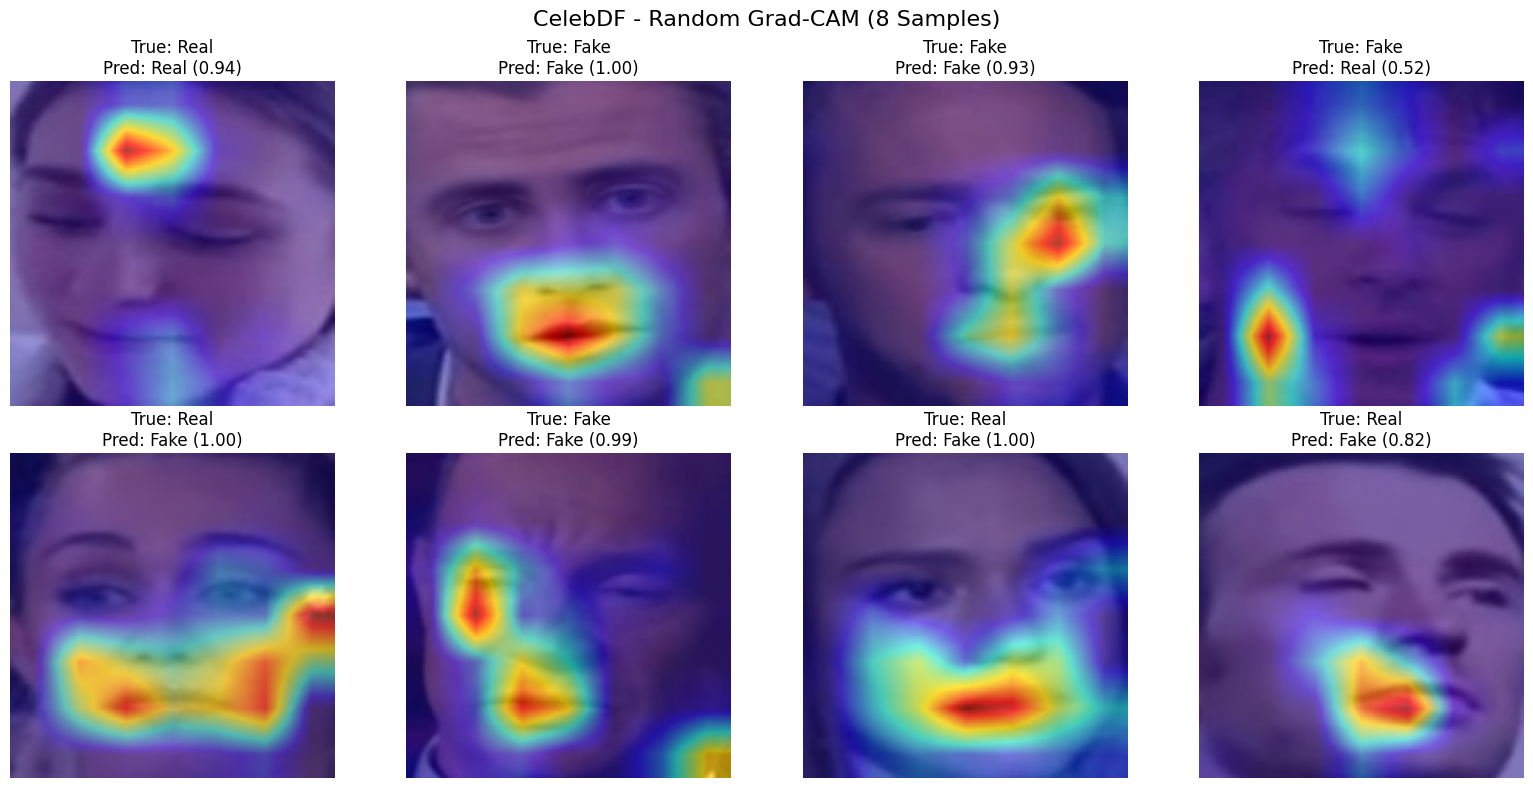

In [29]:
show_batch_gradcam(celebdf_loader, title="CelebDF - Random Grad-CAM (8 Samples)")

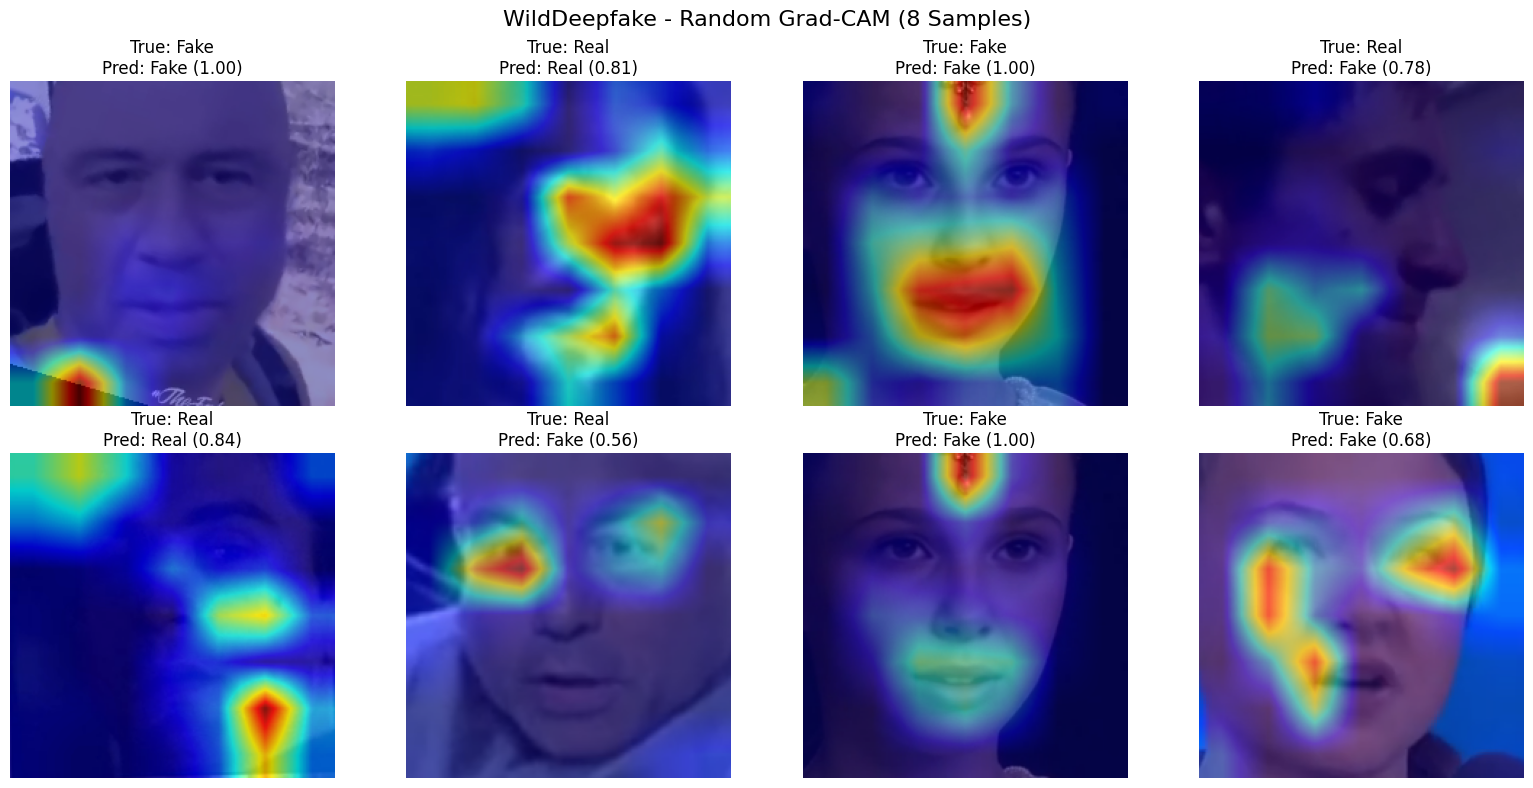

In [30]:
show_batch_gradcam(wilddeepfake_loader, title="WildDeepfake - Random Grad-CAM (8 Samples)")